In [1]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import cm
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

from config_run import goodchips_run

### Binned BTSettl fits

In [66]:
datadir = f"{homedir}/uoedrive/result/CIFIST"
instru = "CRIRES"
target = "W1049B"
band = "K"
tag = "bounds"

In [67]:
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte014.0-5.0', 'lte014.0-5.5', 'lte015.0-5.0', 'lte015.0-5.5', 'lte015.5-5.0', 'lte015.5-5.5', 'lte016.0-5.0', 'lte016.0-5.5', 'lte016.5-5.0', 'lte016.5-5.5', 'lte017.0-5.0', 'lte017.0-5.5', 'lte017.5-5.0', 'lte017.5-5.5', 'lte018.0-5.0'])

In [68]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
lte015.5-5.5,10912353202,11970019672,7826309460
lte016.5-5.5,10954081925,12600765402,8348056413
lte017.0-5.5,11940039902,14427127055,9145369970
lte016.0-5.5,12690421281,13869851155,8509815728
lte017.5-5.5,12931383646,15542387712,9198439155
lte015.5-5.0,15073643176,15085496387,8619473428
lte015.0-5.5,16459762681,15579105948,7969048119
lte016.5-5.0,18675410723,20255639275,10896790672
lte014.0-5.5,18963300419,22776991222,12379085135
lte015.0-5.0,19346080436,19809363876,10532104553


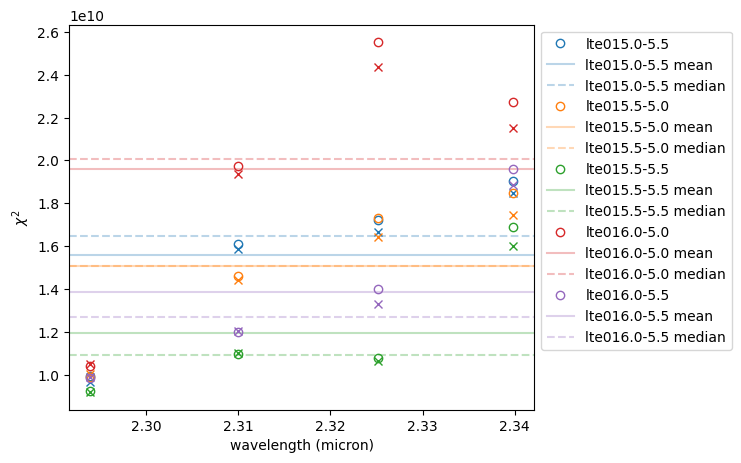

In [72]:
plt.figure(figsize=(6,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lam_points = np.median(np.median(chiplams[modellist[0]], axis=0), axis=1)
for i, key in enumerate(modellist[3:8]):
    plt.plot(lam_points, np.mean(chisq[key].reshape(14, 4), axis=0), "o", mfc="none", color=colors[i], label=f"{key}")
    plt.plot(lam_points, np.median(chisq[key].reshape(14, 4), axis=0), "x", mfc="none", color=colors[i])
    plt.axhline(np.mean(chisq[key]), color=colors[i], alpha=0.3, label=f"{key} mean")
    plt.axhline(np.median(chisq[key]), ls="--", color=colors[i], alpha=0.3, label=f"{key} median")
plt.ylabel("$\chi ^2$")
plt.xlabel("wavelength (micron)")
plt.legend(bbox_to_anchor=(1,1));

In [73]:
model = 'lte015.5-5.5'
nobs = 14
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 4)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 4)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 4)), 2))

#remove outliers
thres = 3
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

masked_vsini = vsini_2d[indices,:]
masked_rv = rv_2d[indices,:]
masked_lld = lld_2d[indices,:]

for i, jj in enumerate(range(4)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: []
rv outliers: []
lld outliers: []
order 0    vsini: 28.4 ± 1.1 km/s    rv: 26.4 ± 0.4 km/s    lld: 0.85 ± 0.20
order 1    vsini: 30.2 ± 1.3 km/s    rv: 24.4 ± 0.3 km/s    lld: 1.00 ± 0.24
order 2    vsini: 27.6 ± 1.7 km/s    rv: 24.6 ± 0.4 km/s    lld: 0.76 ± 0.45
order 3    vsini: 29.9 ± 1.6 km/s    rv: 25.0 ± 0.4 km/s    lld: 1.00 ± 0.23
all orders:     vsini: 28.8 ± 1.8    rv: 24.9 ± 0.8    lld: 0.98 ± 0.32
all orders w/o bad t:    vsini: 28.8 ± 1.8    rv: 24.9 ± 0.8    lld: 0.98 ± 0.32


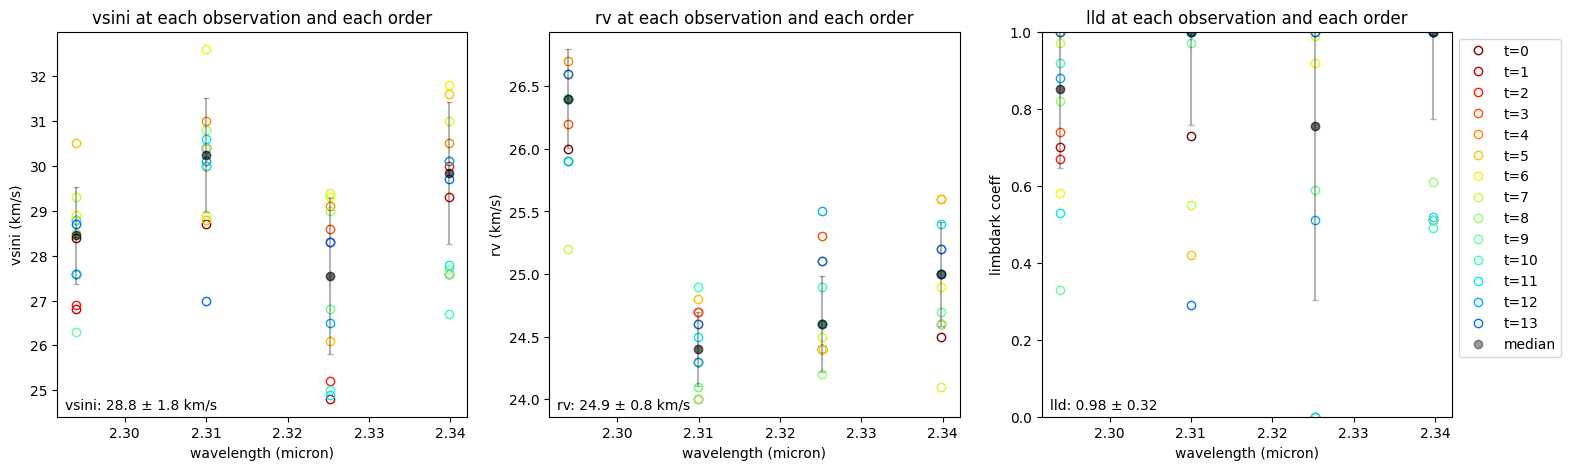

In [74]:
# vsini and rv for bestfittin model
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = masked_vsini
rv_points = masked_rv
lld_points = masked_lld
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points)} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points)} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

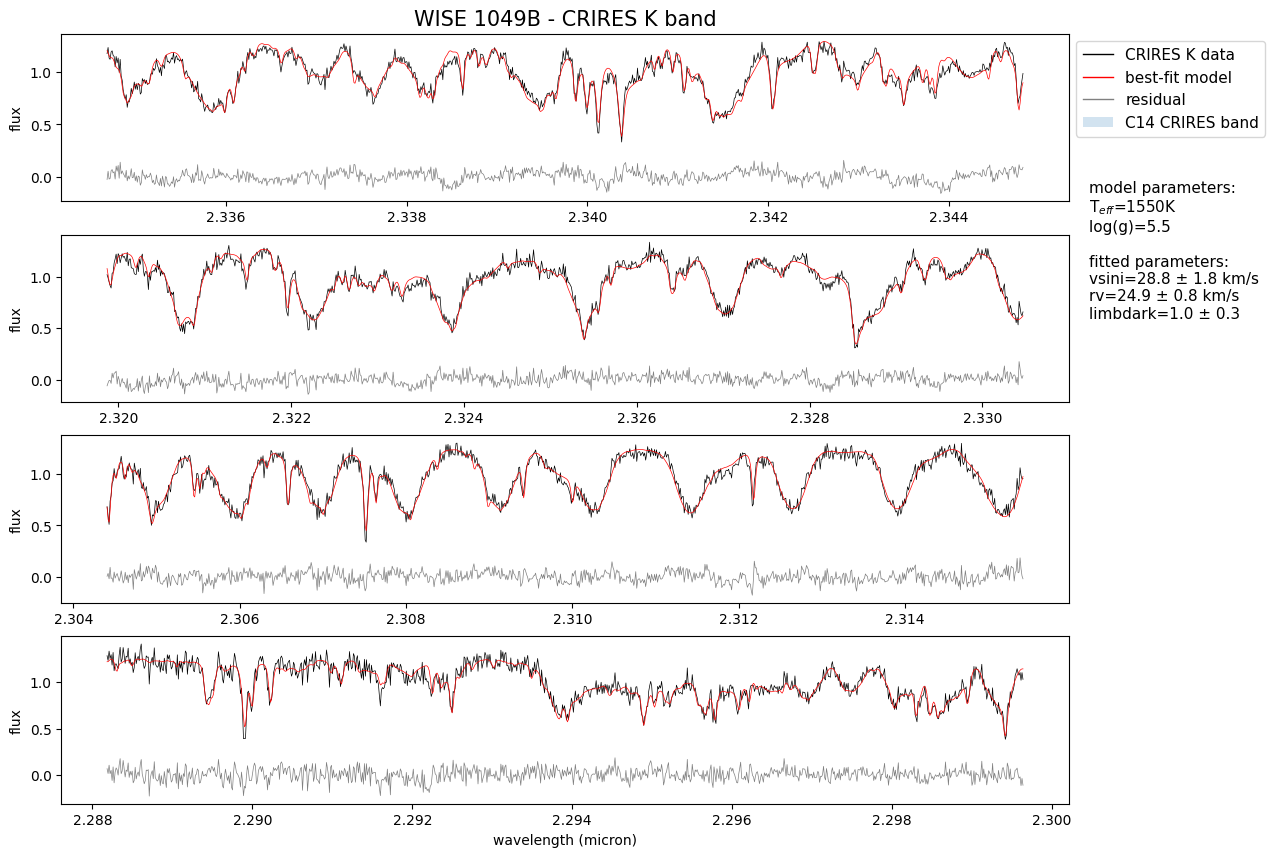

In [33]:
# plot best fitting spectrum
pad = 50
bfit_filename = f'{instru}_{target}_{band}_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['obs1']
fobs = fobs[:20]
wobs = ret['wobs']
plt.figure(figsize=(13,10))
Teff = eval(model[3:8])*100
logg = model[9:12]

t=5
for jj in range(4):
    plt.subplot(4,1, 4-jj)
    plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
    if jj in indices:
        plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
    else:
        plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    #plt.ylim(-0.37,1.26)
    if jj==0:
        plt.xlabel("wavelength (micron)")
    if jj==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="CRIRES K data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title(f"WISE {target[1:]} - CRIRES K band", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n" + 
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes);

### Binned Callie fits

In [50]:
datadir = f"{homedir}/uoedrive/result/Callie"
instru = "CRIRES"
target = "W1049B"
band = "K"
tag = "bounds"

In [51]:
nobs = 14
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
wcoef = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['t1400g1000f4', 't1400g1000f8', 't1500g1000f4', 't1500g1000f8'])

In [52]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
t1500g1000f8,20234159072,21091015001,7545323046
t1400g1000f4,43728557011,39790890237,9639775577
t1500g1000f4,55073734737,51636193404,9862270502
t1400g1000f8,75876023702,86891454675,21827088269


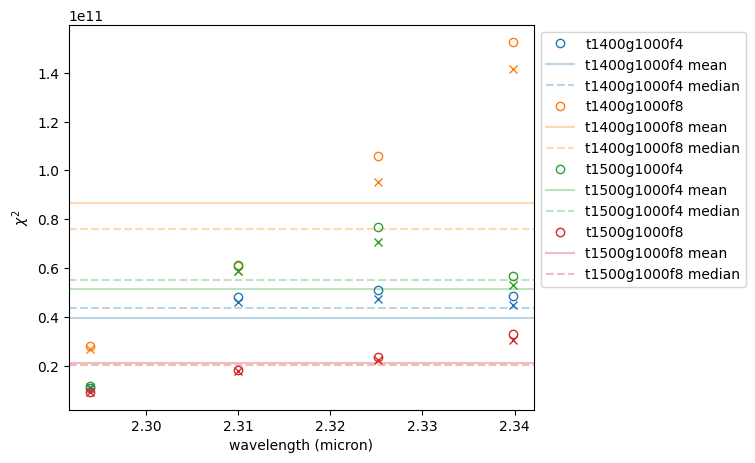

In [53]:
plt.figure(figsize=(6,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lam_points = np.median(np.median(chiplams[modellist[0]], axis=0), axis=1)
for i, key in enumerate(modellist):
    plt.plot(lam_points, np.mean(chisq[key].reshape(14, 4), axis=0), "o", mfc="none", color=colors[i], label=f"{key}")
    plt.plot(lam_points, np.median(chisq[key].reshape(14, 4), axis=0), "x", mfc="none", color=colors[i])
    plt.axhline(np.mean(chisq[key]), color=colors[i], alpha=0.3, label=f"{key} mean")
    plt.axhline(np.median(chisq[key]), ls="--", color=colors[i], alpha=0.3, label=f"{key} median")
plt.ylabel("$\chi ^2$")
plt.xlabel("wavelength (micron)")
plt.legend(bbox_to_anchor=(1,1));

In [54]:
model = 't1500g1000f8'
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 4)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 4)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 4)), 2))

#remove outliers
thres = 3
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
indices_masked = [0,1,2,3,4,5,9,10,11,12,13]

masked_vsini = vsini_2d[indices_masked,:]
masked_rv = rv_2d[indices_masked,:]
masked_lld = lld_2d[indices_masked,:]

for i, jj in enumerate(range(4)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: []
rv outliers: []
lld outliers: []
order 0    vsini: 25.5 ± 1.1 km/s    rv: 26.3 ± 0.3 km/s    lld: 0.58 ± 0.16
order 1    vsini: 22.4 ± 0.9 km/s    rv: 25.6 ± 0.3 km/s    lld: 0.29 ± 0.32
order 2    vsini: 24.4 ± 0.9 km/s    rv: 25.4 ± 0.3 km/s    lld: 0.99 ± 0.20
order 3    vsini: 25.1 ± 1.3 km/s    rv: 25.0 ± 0.5 km/s    lld: 0.46 ± 0.36
all orders:     vsini: 24.5 ± 1.6    rv: 25.5 ± 0.6    lld: 0.58 ± 0.33
all orders w/o bad t:    vsini: 24.3 ± 1.5    rv: 25.6 ± 0.5    lld: 0.58 ± 0.33


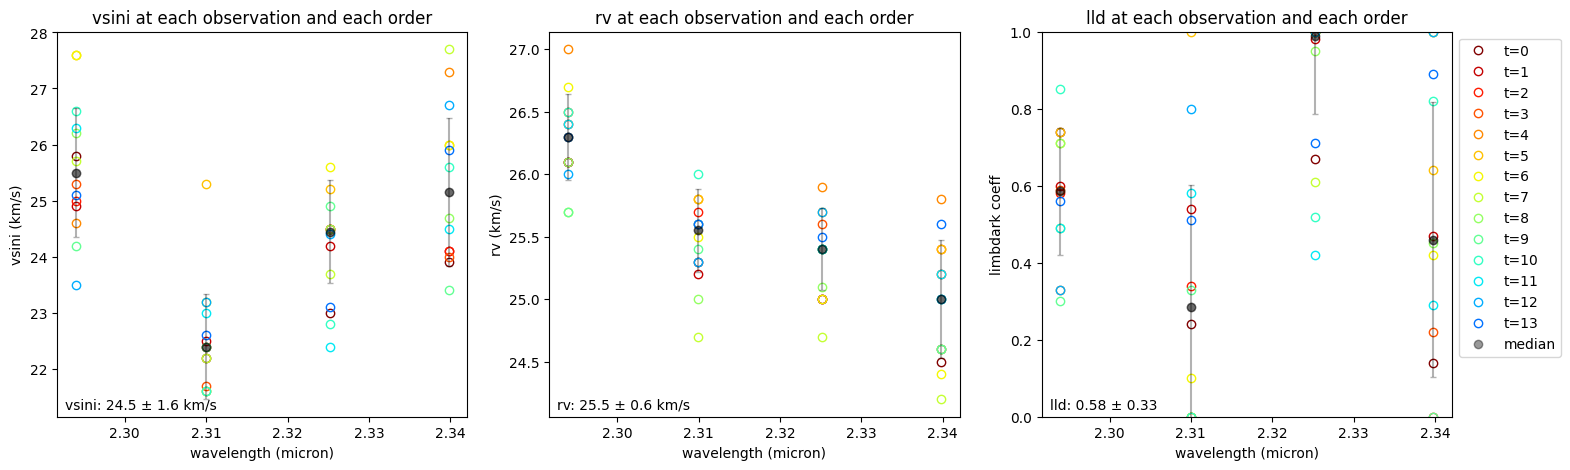

In [55]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

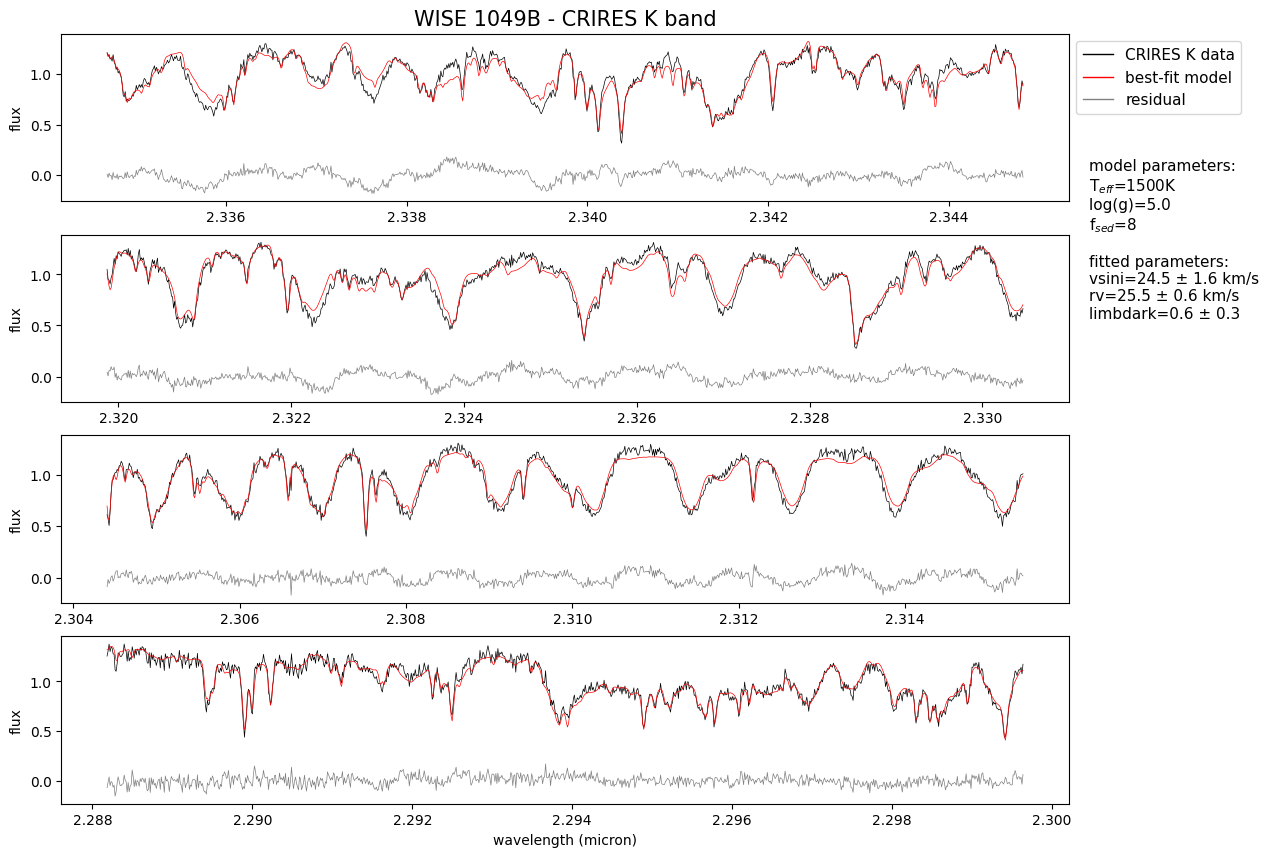

In [65]:
# plot best fitting spectrum
pad = 50
bfit_filename = f'{instru}_{target}_{band}_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['obs1']
fobs = fobs[:20]
wobs = ret['wobs']
plt.figure(figsize=(13,10))
Teff = eval(model[1:5])
logg = 5.0

t=0
for jj in range(4):
    plt.subplot(4,1, 4-jj)
    plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
    if jj in indices:
        plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
    else:
        plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    #plt.ylim(-0.37,1.26)
    if jj==0:
        plt.xlabel("wavelength (micron)")
    if jj==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="CRIRES K data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        #Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title(f"WISE {target[1:]} - CRIRES K band", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n" + "f$_{sed}$=8\n" +
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes);

In [30]:
22.23/c

7.415141164540749e-05